## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read sampled dataset

In [3]:
# Read the sampled dataset
df=pd.read_csv('./CICIDS2017_sample_km.csv')

In [4]:
df=df.dropna()

In [5]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [7]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [8]:
features = df.dtypes[df.dtypes != 'object'].index

In [9]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [10]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [11]:
X_fs = df[fs].values

In [12]:
X_fs.shape

(25490, 46)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [13]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [14]:
X_fss = fcbf.fit_transform(X_fs,y)

In [15]:
X_fss.shape

(25490, 20)

### Re-split train & test sets after feature selection

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.7, test_size = 0.3, random_state = 0,stratify = y)

In [17]:
X_train.shape

(17843, 20)

In [18]:
pd.Series(y_train).value_counts()

0     7158
4     3233
10    2225
2     1795
1     1376
12    1055
14     456
3      146
7      108
6       83
11      81
5       79
9       25
13      15
8        8
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [19]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={14:1000,3:1000,7:1000,6:1000,11:1000,5:1000,9:1000,13:1000,8:1000})

In [20]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [21]:
pd.Series(y_train).value_counts()

0     7158
4     3233
10    2225
2     1795
1     1376
12    1055
14    1000
3     1000
6     1000
5     1000
7     1000
13    1000
9     1000
11    1000
8     1000
Name: count, dtype: int64

In [22]:
criteria = ['gini', 'entropy']

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9428534065646659
Precision of XGBoost: 0.9741449639711584
Recall of XGBoost: 0.9428534065646659
F1-score of XGBoost: 0.9387937851475182
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3068
           1       0.98      1.00      0.99       590
           2       1.00      1.00      1.00       769
           3       0.98      1.00      0.99        62
           4       0.99      0.99      0.99      1386
           5       0.92      0.97      0.94        34
           6       0.92      0.97      0.94        35
           7       0.98      1.00      0.99        47
           8       1.00      1.00      1.00         3
           9       0.75      0.82      0.78        11
          10       1.00      0.99      0.99       953
          11       1.00      1.00      1.00        35
          12       0.98      0.19      0.32       452
          13       0.36      0.83      0.50         6
          14       0.35      0

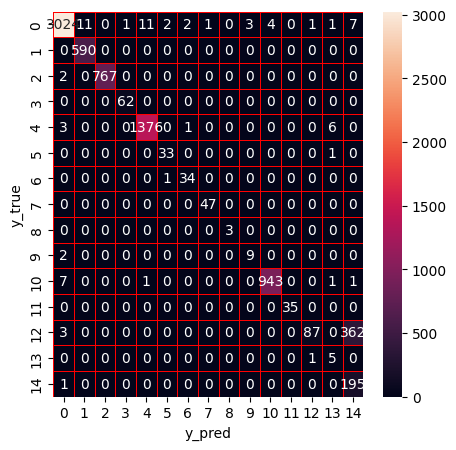

In [23]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [24]:
X_train_hpo, X_val_hpo, y_train_hpo, y_val_hpo = train_test_split(X_train, y_train, train_size=0.9, test_size=0.1, random_state=0, stratify=y_train)

In [25]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val_hpo)
    score = accuracy_score(y_val_hpo, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:18<00:00,  1.11trial/s, best loss: -0.965183752417795]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.3476502830587508, 'max_depth': 67.0, 'n_estimators': 35.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.96015474 0.96518375 0.96362229 0.9628483  0.96594427 0.96439628
 0.9628483  0.9628483  0.96439628 0.96168731]
Average Accuracy: 0.9634 (+/- 0.0016)

Accuracy of XGBoost: 0.947038054138878
Precision of XGBoost: 0.9775408857407986
Recall of XGBoost: 0.947038054138878
F1-score of XGBoost: 0.9426176861538197
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3068
           1       0.99      1.00      0.99       590
           2       1.00      1.00      1.00       769
           3       0.98      1.00      0.99        62
           4       1.00      1.00      1.00      1386
           5       0.92      1.00      0.96        34
           6       0.92      0.97      0.94        35
           7       0.98      1.00      0.99        47
           8       1.00      1.00      1.00         3
           9       1.00      0.73      0.84        11
          10       1.00      0.99

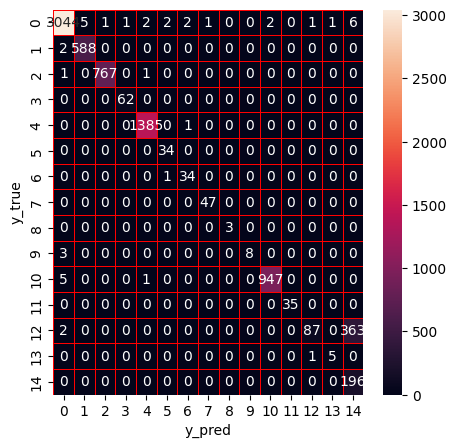

Final Detection Rate (DR) on Test Set: 0.9972
Final False Alarm Rate (FAR) on Test Set: 0.0078



In [26]:
xg = xgb.XGBClassifier(learning_rate=0.3476502830587508, n_estimators=35, max_depth = 67)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(xg, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()


def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")




In [27]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9476919053223486
Precision of RF: 0.9786943200350766
Recall of RF: 0.9476919053223486
F1-score of RF: 0.9431419760957934
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3068
           1       1.00      1.00      1.00       590
           2       1.00      1.00      1.00       769
           3       0.98      1.00      0.99        62
           4       1.00      1.00      1.00      1386
           5       0.92      1.00      0.96        34
           6       1.00      0.97      0.99        35
           7       1.00      1.00      1.00        47
           8       0.75      1.00      0.86         3
           9       1.00      0.73      0.84        11
          10       1.00      1.00      1.00       953
          11       1.00      1.00      1.00        35
          12       0.99      0.19      0.32       452
          13       0.83      0.83      0.83         6
          14       0.35      0.99      0.51       

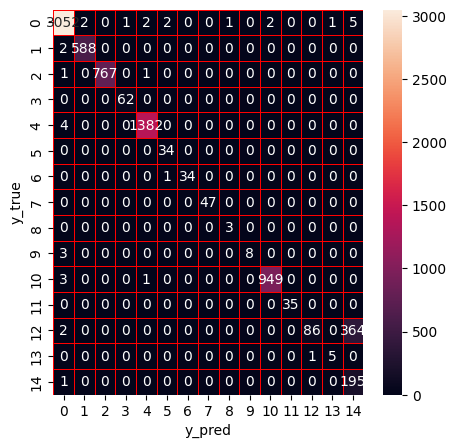

In [28]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [29]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train_hpo,y_train_hpo)
    score=clf.score(X_val_hpo,y_val_hpo)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [03:05<00:00,  9.30s/trial, best loss: -0.9617021276595744]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 50.0, 'max_features': 5.0, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 43.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.95860735 0.96324952 0.96362229 0.9620743  0.96478328 0.96517028
 0.96362229 0.9620743  0.96400929 0.95820433]
Average Accuracy: 0.9625 (+/- 0.0023)

Accuracy of RF: 0.9472995946122662
Precision of RF: 0.9776592970573228
Recall of RF: 0.9472995946122662
F1-score of RF: 0.9428706460523338
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3068
           1       0.99      1.00      0.99       590
           2       1.00      1.00      1.00       769
           3       1.00      0.94      0.97        62
           4       0.99      1.00      1.00      1386
           5       0.94      1.00      0.97        34
           6       1.00      0.97      0.99        35
           7       1.00      1.00      1.00        47
           8       1.00      1.00      1.00         3
           9       1.00      0.91      0.95        11
          10       0.99      1.00      1.00       9

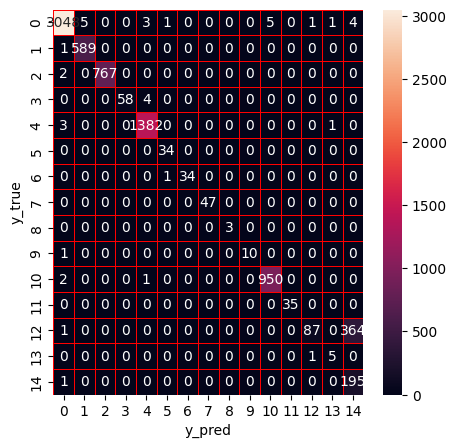

Final Detection Rate (DR) on Test Set: 0.9976
Final False Alarm Rate (FAR) on Test Set: 0.0065



In [30]:
rf_hpo = RandomForestClassifier(n_estimators = 43, min_samples_leaf = 2, max_depth = 50, min_samples_split = 4, max_features = 5, criterion = criteria[best['criterion']])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(rf_hpo, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()


def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [31]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9463842029554074
Precision of DT: 0.9764759435797307
Recall of DT: 0.9463842029554074
F1-score of DT: 0.9420938026224798
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3068
           1       0.99      1.00      0.99       590
           2       1.00      1.00      1.00       769
           3       0.98      0.97      0.98        62
           4       1.00      1.00      1.00      1386
           5       0.92      1.00      0.96        34
           6       1.00      0.97      0.99        35
           7       0.98      1.00      0.99        47
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00        11
          10       1.00      0.99      0.99       953
          11       1.00      1.00      1.00        35
          12       0.97      0.19      0.32       452
          13       0.71      0.83      0.77         6
          14       0.35      0.99      0.51       

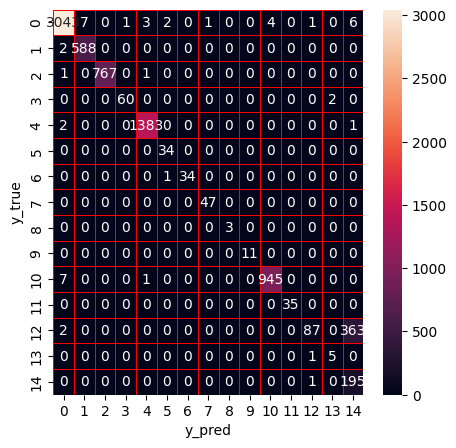

In [32]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [33]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_val_hpo,y_val_hpo)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:04<00:00, 10.03trial/s, best loss: -0.965183752417795] 
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 36.0, 'max_features': 19.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.96092843 0.96363636 0.9624613  0.96052632 0.96517028 0.96362229
 0.96130031 0.96052632 0.96091331 0.95859133]
Average Accuracy: 0.9618 (+/- 0.0018)

Accuracy of DT: 0.9454688112985484
Precision of DT: 0.9753003407398351
Recall of DT: 0.9454688112985484
F1-score of DT: 0.9413752953826994
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3068
           1       0.99      0.99      0.99       590
           2       1.00      1.00      1.00       769
           3       0.97      0.97      0.97        62
           4       1.00      1.00      1.00      1386
           5       0.94      1.00      0.97        34
           6       1.00      0.97      0.99        35
           7       0.98      1.00      0.99        47
           8       1.00      0.67      0.80         3
           9       0.92      1.00      0.96        11
          10       1.00      0.99      0.99       9

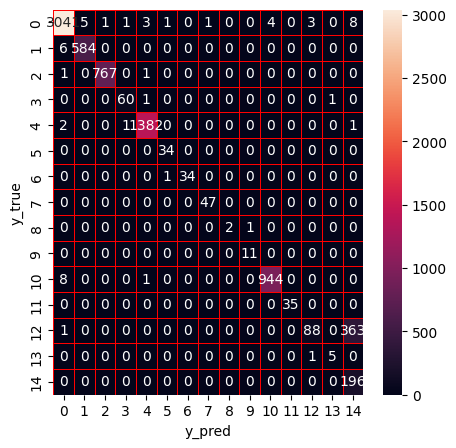

Final Detection Rate (DR) on Test Set: 0.9961
Final False Alarm Rate (FAR) on Test Set: 0.0088



In [34]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 1, max_depth = 36, min_samples_split = 2, max_features = 19, criterion = criteria[best['criterion']])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(dt_hpo, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [35]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9471688243755721
Precision of ET: 0.9782904975791744
Recall of ET: 0.9471688243755721
F1-score of ET: 0.9426718459532144
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3068
           1       0.99      1.00      0.99       590
           2       1.00      1.00      1.00       769
           3       0.98      0.98      0.98        62
           4       1.00      1.00      1.00      1386
           5       0.92      1.00      0.96        34
           6       1.00      0.97      0.99        35
           7       1.00      1.00      1.00        47
           8       0.67      0.67      0.67         3
           9       1.00      0.73      0.84        11
          10       1.00      1.00      1.00       953
          11       1.00      1.00      1.00        35
          12       0.99      0.19      0.32       452
          13       0.71      0.83      0.77         6
          14       0.35      0.99      0.51       

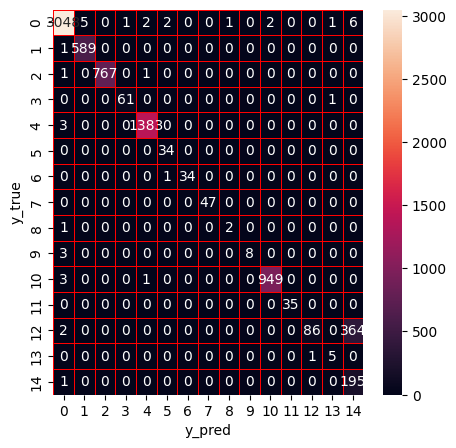

In [36]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [37]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_val_hpo,y_val_hpo)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:57<00:00,  2.89s/trial, best loss: -0.9647969052224371]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 26.0, 'max_features': 16.0, 'min_samples_leaf': 1.0, 'min_samples_split': 8.0, 'n_estimators': 152.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.95512573 0.9582205  0.95665635 0.95472136 0.95897833 0.96130031
 0.95859133 0.95626935 0.95897833 0.95394737]
Average Accuracy: 0.9573 (+/- 0.0022)

Accuracy of ET: 0.9404995423041715
Precision of ET: 0.9757221993523614
Recall of ET: 0.9404995423041715
F1-score of ET: 0.9342713199524874
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3068
           1       0.98      1.00      0.99       590
           2       1.00      1.00      1.00       769
           3       1.00      0.89      0.94        62
           4       0.99      1.00      0.99      1386
           5       0.92      1.00      0.96        34
           6       1.00      0.97      0.99        35
           7       1.00      1.00      1.00        47
           8       0.67      0.67      0.67         3
           9       1.00      0.73      0.84        11
          10       1.00      1.00      1.00       9

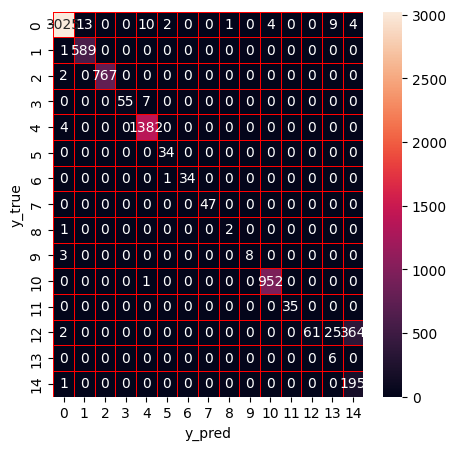

Final Detection Rate (DR) on Test Set: 0.9969
Final False Alarm Rate (FAR) on Test Set: 0.0140



In [38]:
et_hpo = ExtraTreesClassifier(n_estimators = 152, min_samples_leaf = 1, max_depth = 26, min_samples_split = 8, criterion=criteria[best['criterion']])
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(et_hpo, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

et_hpo.fit(X_train,y_train)
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")


In [39]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [40]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,4,4,4,4
1,0,0,0,0
2,0,0,0,0
3,14,14,14,14
4,1,1,1,1


In [41]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [42]:
dt_train.shape

(25842, 1)

In [43]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9458611220086308
Precision of Stacking: 0.9765801056376264
Recall of Stacking: 0.9458611220086308
F1-score of Stacking: 0.9416549326259313
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3068
           1       0.99      0.99      0.99       590
           2       0.99      1.00      0.99       769
           3       1.00      1.00      1.00        62
           4       1.00      1.00      1.00      1386
           5       0.94      1.00      0.97        34
           6       1.00      0.97      0.99        35
           7       1.00      1.00      1.00        47
           8       1.00      0.67      0.80         3
           9       0.92      1.00      0.96        11
          10       1.00      0.99      0.99       953
          11       1.00      1.00      1.00        35
          12       0.98      0.19      0.32       452
          13       1.00      0.83      0.91         6
          14       0.35   

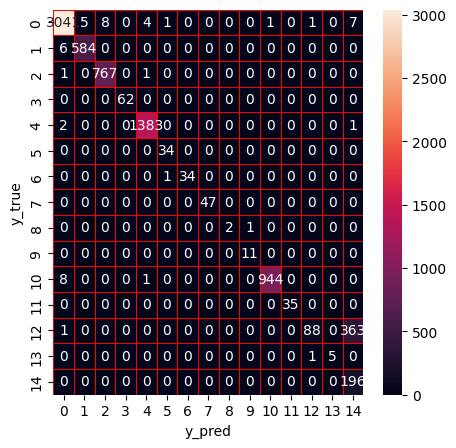

In [44]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [45]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train_hpo, y_train_hpo)
    y_pred = clf.predict(X_val_hpo)
    score = accuracy_score(y_val_hpo, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:16<00:00,  1.18trial/s, best loss: -0.962862669245648]
XGBoost: Hyperopt estimated optimum {'learning_rate': 1.0377595071456205, 'max_depth': 30.0, 'n_estimators': 45.0}


--- Tenfold Cross-Validation Results ---
Scores for each fold: [0.96092843 0.96441006 0.96400929 0.9624613  0.96555728 0.96439628
 0.96323529 0.96168731 0.96362229 0.96168731]
Average Accuracy: 0.9632 (+/- 0.0014)

Accuracy of XGBoost: 0.9457303517719368
Precision of XGBoost: 0.9764099537282555
Recall of XGBoost: 0.9457303517719368
F1-score of XGBoost: 0.9415079306150761
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3068
           1       1.00      0.99      0.99       590
           2       0.99      1.00      1.00       769
           3       0.90      1.00      0.95        62
           4       1.00      1.00      1.00      1386
           5       0.94      1.00      0.97        34
           6       1.00      0.97      0.99        35
           7       1.00      1.00      1.00        47
           8       0.67      0.67      0.67         3
           9       0.91      0.91      0.91        11
          10       1.00      0.

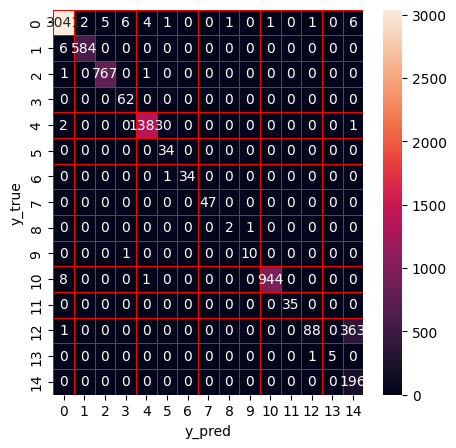

Final Detection Rate (DR) on Test Set: 0.9961
Final False Alarm Rate (FAR) on Test Set: 0.0088



In [46]:
xg = xgb.XGBClassifier(learning_rate=1.0377595071456205, n_estimators = 45, max_depth = 30)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(xg, X_train, y_train, cv=kfold, scoring='accuracy')

print("--- Tenfold Cross-Validation Results ---")
print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")

xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tn = cm[0,0]
fp = cm[0,1:].sum()
fn = cm[1:,0].sum()
tp = cm[1:,1:].sum()

def far_score_multiclass(y_true, y_predict):
    """
    Calculates the False Alarm Rate for a multi-class confusion matrix.
    Assumes class 0 is the "Normal" or negative class.
    """
    cm = confusion_matrix(y_true, y_predict)

    tn = cm[0, 0]

    fp = cm[0, 1:].sum()
    
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    return false_alarm_rate


detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0.0
false_alarm_rate = far_score_multiclass(y_true, y_predict)

print(f"Final Detection Rate (DR) on Test Set: {detection_rate:.4f}")
print(f"Final False Alarm Rate (FAR) on Test Set: {false_alarm_rate:.4f}\n")
